In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import kendalltau
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance

In [44]:
df = pd.read_csv(r"C:\Users\bichh\Documents\HR and employee performance\employee_performance_dataset.csv")

In [45]:
df.head()

employee_id         department     region  education gender  \
0         8724         Technology  region_26  Bachelors      m   
1        74430                 HR   region_4  Bachelors      f   
2        72255  Sales & Marketing  region_13  Bachelors      m   
3        38562        Procurement   region_2  Bachelors      f   
4        64486            Finance  region_29  Bachelors      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   24                   NaN   
1               other                1   31                   3.0   
2               other                1   31                   1.0   
3               other                3   31                   2.0   
4            sourcing                1   30                   4.0   

   length_of_service  KPIs_met_more_than_80  awards_won  avg_training_score  
0                  1                      1           0                  77  
1                  5                      0           0                  51  
2                  4                      0           0                  47  
3                  9                      0           0                  65  
4                  7                      0           0                  61

In [46]:
print(df.shape)
print(df.describe())
print(df.info())
print(df.columns)

(17417, 13)
        employee_id  no_of_trainings           age  previous_year_rating  \
count  17417.000000     17417.000000  17417.000000          16054.000000   
mean   39083.491129         1.250732     34.807774              3.345459   
std    22707.024087         0.595692      7.694046              1.265386   
min        3.000000         1.000000     20.000000              1.000000   
25%    19281.000000         1.000000     29.000000              3.000000   
50%    39122.000000         1.000000     33.000000              3.000000   
75%    58838.000000         1.000000     39.000000              4.000000   
max    78295.000000         9.000000     60.000000              5.000000   

       length_of_service  KPIs_met_more_than_80    awards_won  \
count       17417.000000           17417.000000  17417.000000   
mean            5.801860               0.358845      0.023368   
std             4.175533               0.479675      0.151074   
min             1.000000               0.00

ƒê·ªÉ ph√π h·ª£p v·ªõi m·ª•c ti√™u v√† y√™u c·∫ßu c·ªßa project, c≈©ng nh∆∞ ƒë·ªÉ thu·∫≠n ti·ªán h∆°n trong vi·ªác ph√¢n t√≠ch,  c·∫ßn ph·∫£i ƒë·ªïi t√™n c√°c c·ªôt columns

In [47]:
# ƒë·ªïi t√™n c·ªôt
# T·∫°o dictionary mapping c·ªôt c≈© -> c·ªôt m·ªõi
new_column_names = {
    'employee_id': 'employee_id',
    'department': 'department',
    'region': 'region',
    'education': 'education',
    'gender': 'gender',
    'recruitment_channel': 'recruitment_channel',
    'no_of_trainings': 'training_count',
    'age': 'age',
    'previous_year_rating': 'performance_score',
    'length_of_service': 'service_years',
    'KPIs_met_more_than_80': 'KPIs_met_more_than_80',
    'awards_won': 'awards',
    'avg_training_score': 'avg_training_score'
}

# ƒê·ªïi t√™n c·ªôt
df = df.rename(columns=new_column_names)

Ti·∫øp theo c·∫ßn ph·∫£i x·ª≠ l√Ω missing values trong t·∫≠p d·ªØ li·ªáu:
- missing value trong c·ªôt performance_score v√† education
- x·ª≠ l√Ω b·∫±ng c√°ch thay c√°c missing value = mode
Sau ƒë√≥, x·ª≠ l√Ω duplicate

In [48]:
# missing value
missing_info = pd.DataFrame({
    'Missing Values': df.isnull().sum(),
    'Percentage': df.isnull().mean() * 100
})

# S·∫Øp x·∫øp gi·∫£m d·∫ßn theo s·ªë missing value
print(missing_info.sort_values(by='Missing Values', ascending=False))

# Danh s√°ch c√°c c·ªôt mu·ªën ƒëi·ªÅn missing b·∫±ng mode
cols_to_fill = ['performance_score', 'education']

for col in cols_to_fill:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

#duplicates
# Lo·∫°i b·ªè duplicate
df = df.drop_duplicates(subset='employee_id', keep='first')
print("duplicate: ", df.duplicated().sum())

                       Missing Values  Percentage
performance_score                1363    7.825688
education                         771    4.426710
employee_id                         0    0.000000
region                              0    0.000000
department                          0    0.000000
gender                              0    0.000000
recruitment_channel                 0    0.000000
training_count                      0    0.000000
age                                 0    0.000000
service_years                       0    0.000000
KPIs_met_more_than_80               0    0.000000
awards                              0    0.000000
avg_training_score                  0    0.000000
duplicate:  0


In [49]:
#fixing error
df['gender'] = df['gender'].map({'m': 'male', 'f': 'female'})

======================EDA=======================
1. Xem s·ª± ph√¢n b·ªï c·ªßa  Performance score
2. Bi·∫øn ph√¢n lo·∫°i:
   - xem s·ª± ph√¢n b·ªï [department, region, education, gender, recruitment_channel, KPIs_met_more_than_80, awards]
   - xem m·ªëi quan h·ªá v·ªõi  performance_score
3. Bi·∫øn li√™n t·ª•c:
   - xem s·ª± ph√¢n b·ªï : [ age, service_years, avg_training_score, training_count]
   - xem xu h∆∞·ªõng thay ƒë·ªïi v·ªõi performance_score
4. Ph√¢n t√≠ch t∆∞∆°ng quan
   - t∆∞∆°ng quan gi·ªØa c√°c bi·∫øn li√™n t·ª•c
   - t∆∞∆°ng quan gi·ªØa bi·∫øn li√™n t·ª•c v√† performance_score
   - t∆∞∆°ng quan gi·ªØa bi·∫øn ph√¢n lo·∫°i v√† performance_score

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\1323954761.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='performance_score', data=df, palette='viridis')


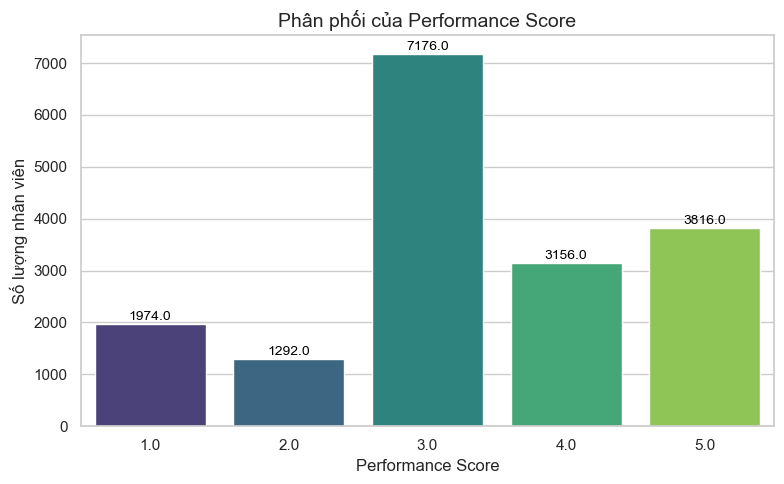

In [50]:
#1. Xem s·ª± ph√¢n b·ªï c·ªßa Performance score
sns.set(style="whitegrid")
# Bi·ªÉu ƒë·ªì ph√¢n ph·ªëi performance_score
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='performance_score', data=df, palette='viridis')
# Th√™m nh√£n s·ªë l∆∞·ª£ng l√™n t·ª´ng c·ªôt
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Ph√¢n ph·ªëi c·ªßa Performance Score', fontsize=14)
plt.xlabel('Performance Score')
plt.ylabel('S·ªë l∆∞·ª£ng nh√¢n vi√™n')
plt.tight_layout()
plt.show()

1. Xem s·ª± ph√¢n b·ªï c·ªßa Performance score
Nh·∫≠n x√©t: Ph√¢n ph·ªëi b·ªã l·ªách r√µ r·ªát, v·ªõi l·ªõp 3.0 chi·∫øm ∆∞u th·∫ø v∆∞·ª£t tr·ªôi.
T·ª∑ l·ªá ph·∫ßn trƒÉm c√°c l·ªõp:
- 3.0 ‚Üí 41.2%
- 5.0 ‚Üí 21.9%
- 4.0 ‚Üí 18.1%
- 1.0 ‚Üí 11.3%
- 2.0 ‚Üí 7.4%

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\2734705392.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


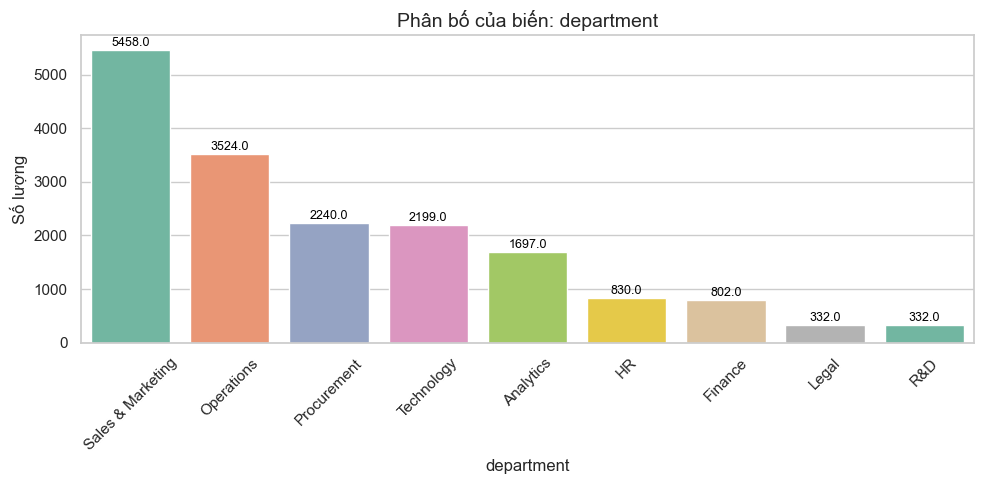

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\2734705392.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


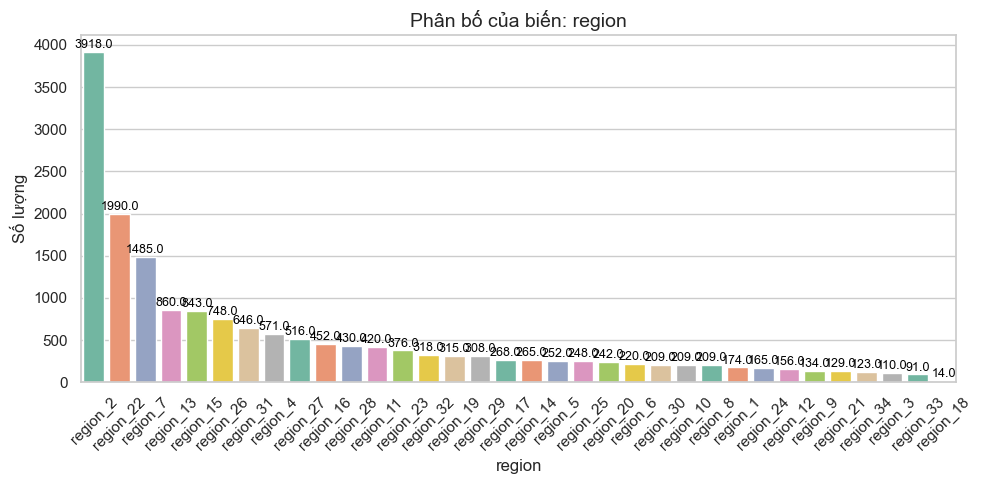

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\2734705392.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


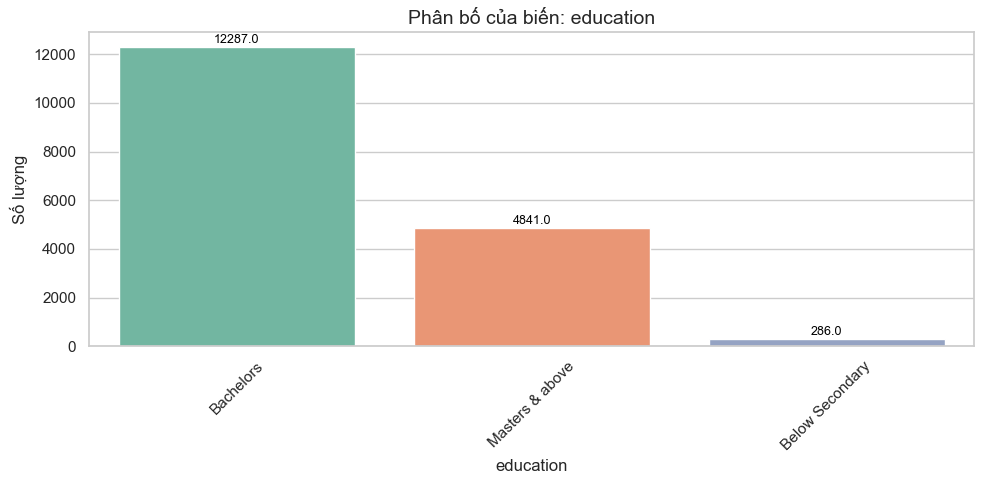

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\2734705392.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


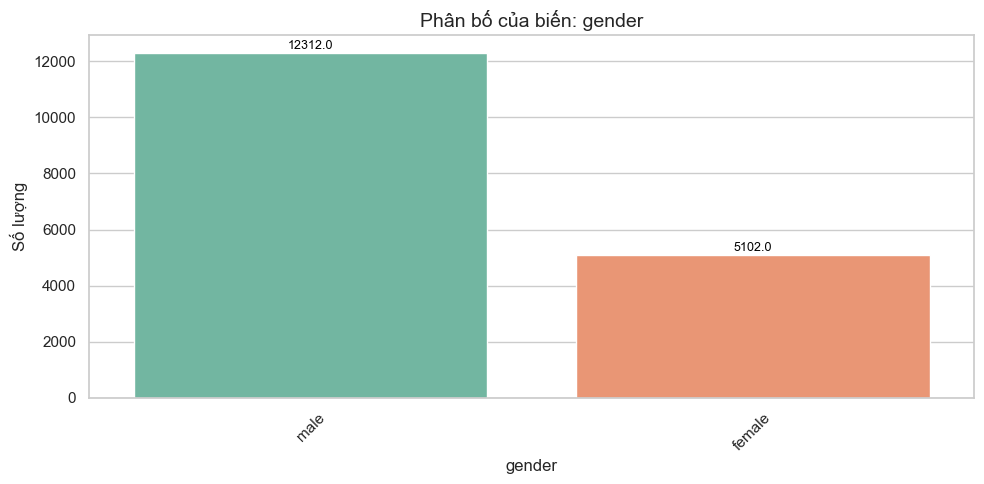

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\2734705392.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


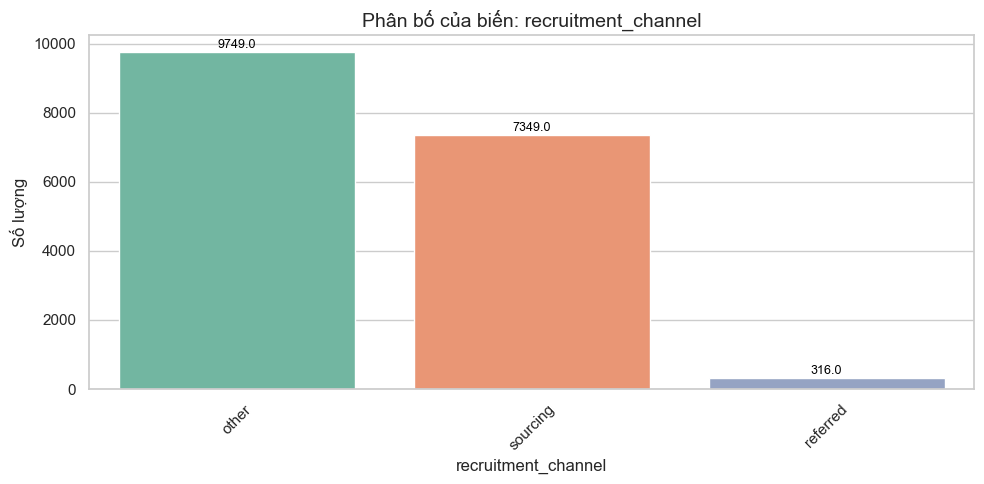

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\2734705392.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


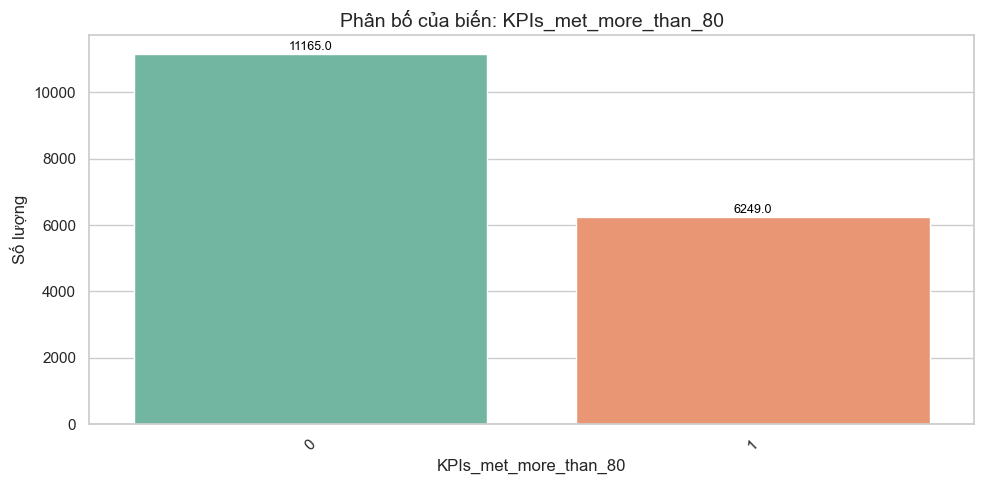

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\2734705392.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')


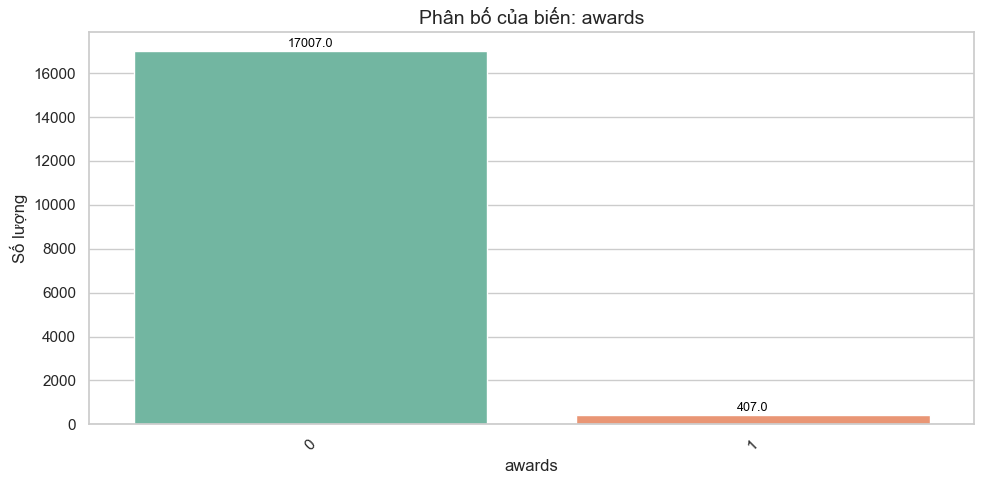

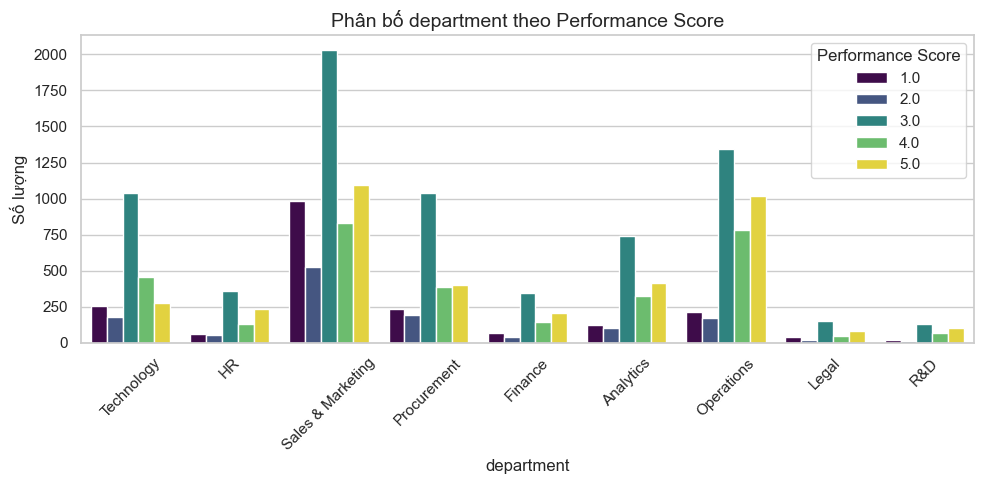

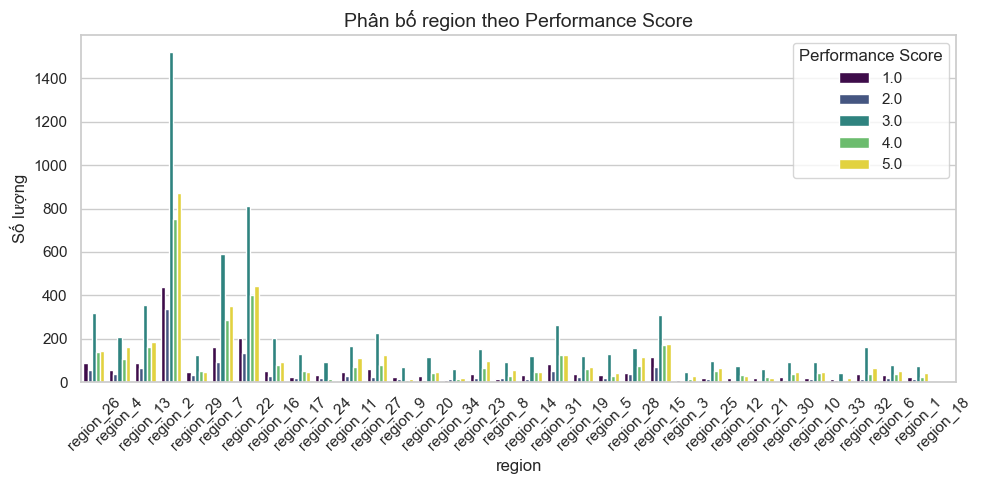

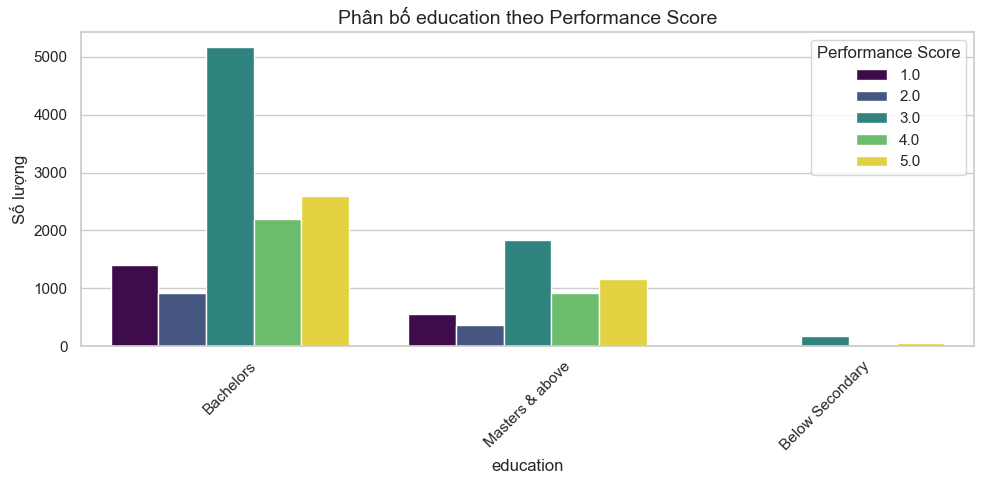

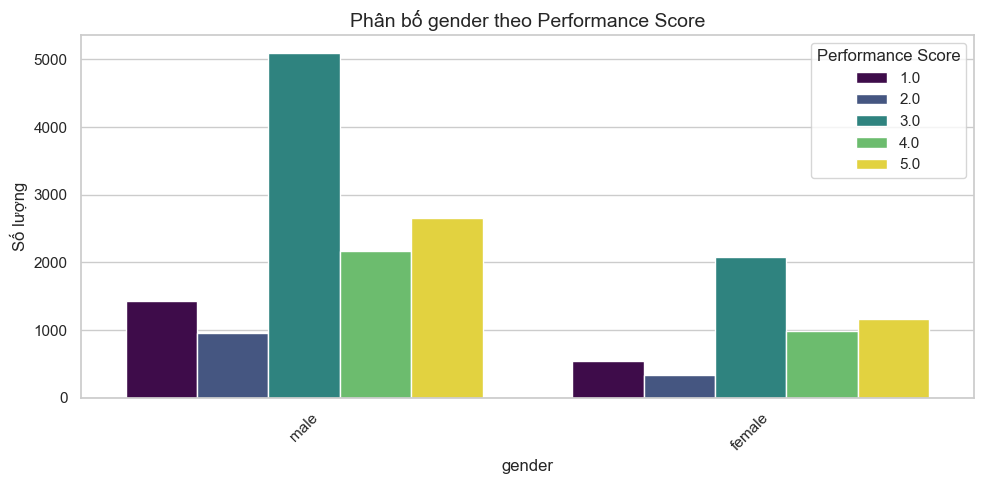

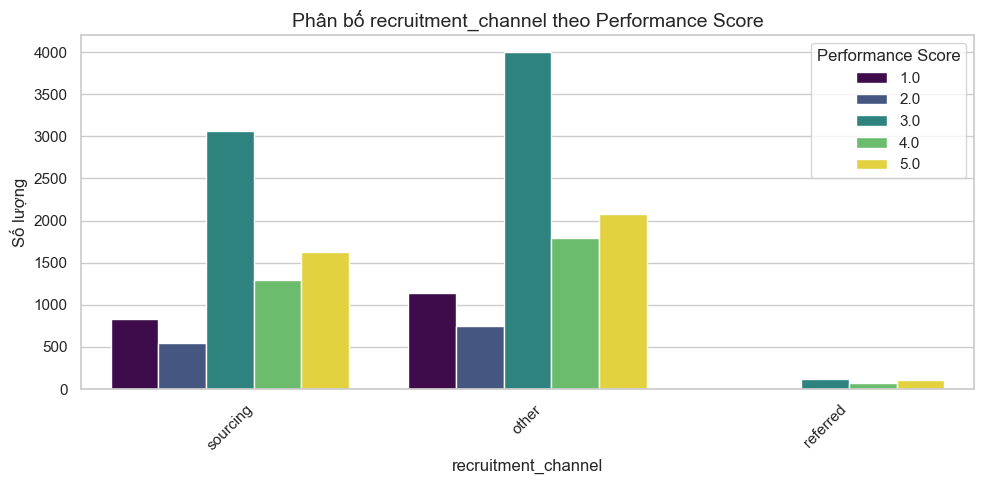

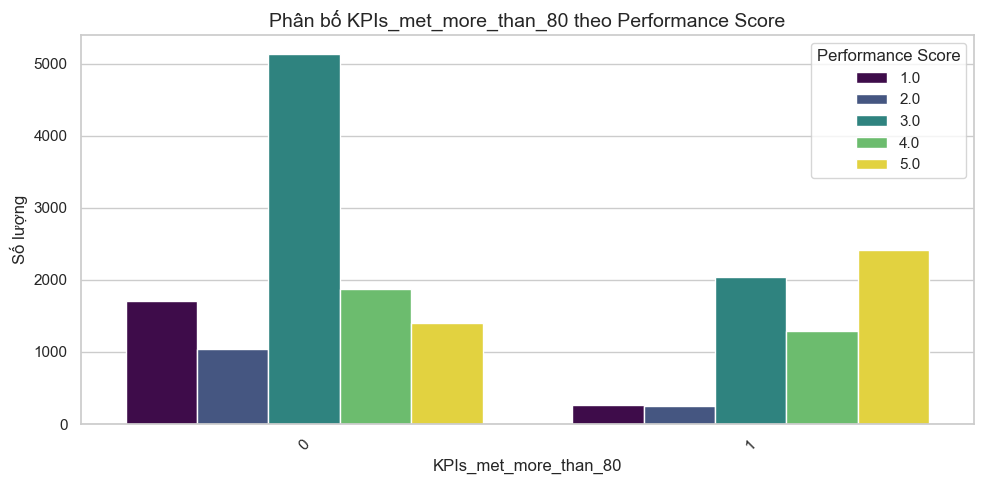

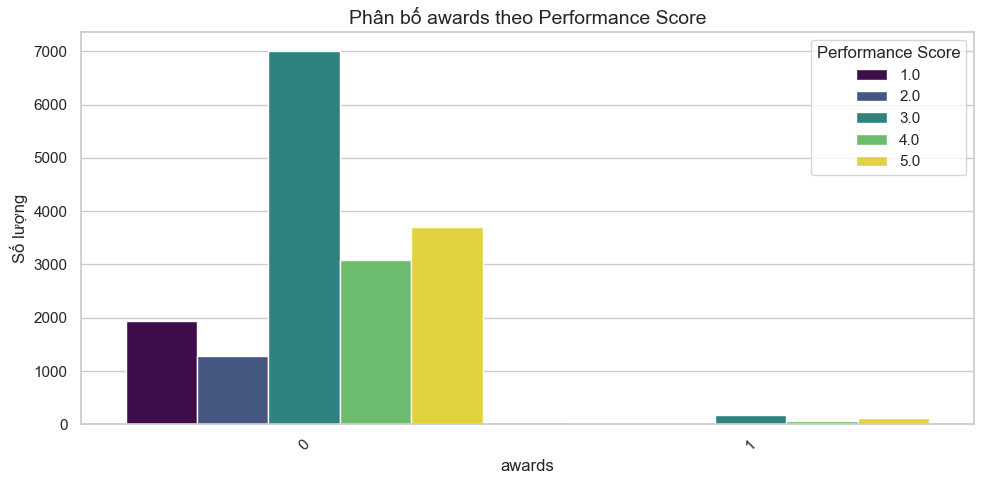

In [51]:
# 2. Bi·∫øn ph√¢n lo·∫°i
#xem s·ª± ph√¢n b·ªï [department, region, education, gender, recruitment_channel, KPIs_met_more_than_80, awards]
# Danh s√°ch c√°c bi·∫øn ph√¢n lo·∫°i c·∫ßn ph√¢n t√≠ch
categorical_cols = [
    'department', 'region', 'education', 'gender',
    'recruitment_channel', 'KPIs_met_more_than_80', 'awards'
]
sns.set(style="whitegrid")
# V·∫Ω bi·ªÉu ƒë·ªì cho t·ª´ng bi·∫øn
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')
    
    # Th√™m nh√£n s·ªë l∆∞·ª£ng l√™n t·ª´ng c·ªôt
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    plt.title(f'Ph√¢n b·ªë c·ªßa bi·∫øn: {col}', fontsize=14)
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('S·ªë l∆∞·ª£ng')
    plt.tight_layout()
    plt.show()

#xem m·ªëi quan h·ªá v·ªõi performance_score
# Bi·ªÉu ƒë·ªì c·ªôt ch·ªìng gi·ªØa bi·∫øn ph√¢n lo·∫°i v√† performance_score
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data=df, x=col, hue='performance_score', palette='viridis')
    plt.title(f'Ph√¢n b·ªë {col} theo Performance Score', fontsize=14)
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('S·ªë l∆∞·ª£ng')
    plt.legend(title='Performance Score')
    plt.tight_layout()
    plt.show()


Nh·∫≠n x√©t:

2. Bi·∫øn ph√¢n lo·∫°i
- V·ªÅ s·ª± ph√¢n b·ªï:
  - department: Sales & Marketing chi·∫øm h∆°n 1/3 t·ªïng s·ªë nh√¢n vi√™n, C√°c ph√≤ng nh∆∞ Legal, R&D c√≥ s·ªë l∆∞·ª£ng r·∫•t nh·ªè,
  - region: region_1 chi·∫øm t·ª∑ tr·ªçng v∆∞·ª£t tr·ªôi, g·∫ßn g·∫•p ƒë√¥i nh√≥m k·∫ø ti·∫øp,C√≥ nhi·ªÅu nh√≥m nh·ªè (region_28‚Äì30) v·ªõi s·ªë l∆∞·ª£ng c·ª±c th·∫•p
  - education: Ph·∫ßn l·ªõn nh√¢n vi√™n c√≥ tr√¨nh ƒë·ªô Bachelors, Nh√≥m Below Secondary r·∫•t nh·ªè
  - gender: T·ª∑ l·ªá nam cao h∆°n g·∫•p ƒë√¥i n·ªØ
  - recruitment_channel: K√™nh ‚Äúother‚Äù chi·∫øm h∆°n m·ªôt n·ª≠a t·ªïng s·ªë, ‚Äúreferred‚Äù c·ª±c k·ª≥ √≠t
  - KPI_met_more_than_80: G·∫ßn 2/3 nh√¢n vi√™n kh√¥ng ƒë·∫°t KPI tr√™n 80%, Nh√≥m ƒë·∫°t KPI tuy √≠t h∆°n nh∆∞ng c√≥ th·ªÉ l√† nh√≥m c√≥ hi·ªáu su·∫•t cao
  - awards: Ch·ªâ kho·∫£ng 2% nh√¢n vi√™n t·ª´ng nh·∫≠n gi·∫£i th∆∞·ªüng

- V·ªÅ m·ªëi quan h·ªá v·ªõi  performance_score:
     - department:

       + Sales & Marketing c√≥ s·ªë l∆∞·ª£ng nh√¢n vi√™n cao nh·∫•t, nh∆∞ng ph·∫ßn l·ªõn t·∫≠p trung ·ªü ƒëi·ªÉm 3.0 ‚Üí hi·ªáu su·∫•t trung b√¨nh.
       + Technology v√† Analytics c√≥ t·ª∑ l·ªá cao h∆°n ·ªü ƒëi·ªÉm 4.0‚Äì5.0 ‚Üí c√≥ th·ªÉ l√† nh√≥m hi·ªáu su·∫•t t·ªët.
       + HR, Legal, v√† R&D c√≥ s·ªë l∆∞·ª£ng √≠t

    - region:
      + Region_26 n·ªïi b·∫≠t nh∆∞ng l·ªách v·ªÅ ƒëi·ªÉm th·∫•p:C√≥ s·ªë l∆∞·ª£ng nh√¢n vi√™n cao, nh∆∞ng ph·∫ßn l·ªõn ƒë·∫°t performance_score = 1.0
      + Region_1 v√† Region_13 c√≥ ph√¢n ph·ªëi ƒëa d·∫°ng: C√≥ s·ª± hi·ªán di·ªán ·ªü nhi·ªÅu m·ª©c ƒëi·ªÉm, ƒë·∫∑c bi·ªát l√† 3.0 v√† 4.0,
      + Nh·ªØng v√πng nh∆∞ region_30, region_29,... c√≥ s·ªë l∆∞·ª£ng r·∫•t √≠t
    - education:
      + Bachelors chi·∫øm ∆∞u th·∫ø nh∆∞ng hi·ªáu su·∫•t trung b√¨nh: S·ªë l∆∞·ª£ng l·ªõn nh·∫•t n·∫±m ·ªü nh√≥m Bachelors, ch·ªß y·∫øu ƒë·∫°t ƒëi·ªÉm 3.0
      + Masters & above c√≥ xu h∆∞·ªõng ƒëi·ªÉm cao h∆°n: D√π s·ªë l∆∞·ª£ng √≠t h∆°n, nh∆∞ng t·ª∑ l·ªá ƒëi·ªÉm 4.0 v√† 5.0 cao h∆°n
      + Below Secondary qu√° √≠t v√† ph√¢n ph·ªëi kh√¥ng r√µ r√†ng
    - gender:
      + Nam chi·∫øm s·ªë l∆∞·ª£ng v∆∞·ª£t tr·ªôi, nh∆∞ng t·∫≠p trung ·ªü ƒëi·ªÉm trung b√¨nh: Nam gi·ªõi c√≥ s·ªë l∆∞·ª£ng l·ªõn nh·∫•t ·ªü ƒëi·ªÉm 3.0, sau ƒë√≥ l√† 4.0 v√† 5.0.
      + N·ªØ c√≥ ph√¢n ph·ªëi ƒëi·ªÉm hi·ªáu su·∫•t c√¢n b·∫±ng h∆°n: D√π s·ªë l∆∞·ª£ng n·ªØ √≠t h∆°n, nh∆∞ng ph√¢n ph·ªëi ƒëi·ªÉm hi·ªáu su·∫•t ƒëa d·∫°ng h∆°n.ƒê·∫∑c bi·ªát, t·ª∑ l·ªá n·ªØ ƒë·∫°t ƒëi·ªÉm 5.0 kh√° cao so v·ªõi t·ªïng s·ªë n·ªØ
    - recruiment_channel:
      + K√™nh ‚Äúother‚Äù chi·∫øm s·ªë l∆∞·ª£ng l·ªõn nh∆∞ng hi·ªáu su·∫•t trung b√¨nh: S·ªë l∆∞·ª£ng nh√¢n vi√™n t·ª´ k√™nh ‚Äúother‚Äù cao nh·∫•t, ch·ªß y·∫øu ƒë·∫°t ƒëi·ªÉm 3.0
      + K√™nh ‚Äúsourcing‚Äù c√≥ ph√¢n ph·ªëi ƒëa d·∫°ng h∆°n: C√≥ s·ªë l∆∞·ª£ng kh√° l·ªõn v√† ph√¢n ph·ªëi ƒë·ªÅu ·ªü c√°c m·ª©c ƒëi·ªÉm t·ª´ 2.0 ƒë·∫øn 5.0. ƒê·∫∑c bi·ªát, c√≥ t·ª∑ l·ªá kh√° cao ·ªü ƒëi·ªÉm 4.0 v√† 5.0
      + K√™nh ‚Äúreferred‚Äù √≠t nh∆∞ng c√≥ xu h∆∞·ªõng hi·ªáu su·∫•t cao: D√π s·ªë l∆∞·ª£ng r·∫•t nh·ªè, nh∆∞ng t·ª∑ l·ªá ƒëi·ªÉm 4.0 v√† 5.0 cao h∆°n h·∫≥n so v·ªõi c√°c k√™nh kh√°c.
    - KPIS_met_more_than_80:
      + Nh√≥m kh√¥ng ƒë·∫°t KPI (0) c√≥ xu h∆∞·ªõng ƒëi·ªÉm th·∫•p: Ph·∫ßn l·ªõn nh√¢n vi√™n trong nh√≥m n√†y c√≥ ƒëi·ªÉm 2.0 v√† 3.0. R·∫•t √≠t ng∆∞·ªùi ƒë·∫°t ƒëi·ªÉm 4.0 ho·∫∑c 5.0
      + Nh√≥m ƒë·∫°t KPI (1) c√≥ ph√¢n ph·ªëi ƒëi·ªÉm cao h∆°n. C√≥ s·ª± hi·ªán di·ªán r√µ r·ªát ·ªü ƒëi·ªÉm 4.0 v√† 5.0 ‚Üí cho th·∫•y nh√≥m n√†y c√≥ hi·ªáu su·∫•t v∆∞·ª£t tr·ªôi. Ph√¢n ph·ªëi ƒë·ªÅu h∆°n, √≠t t·∫≠p trung ·ªü ƒëi·ªÉm th·∫•p ‚Üí ƒë√¢y l√† t√≠n hi·ªáu r·∫•t m·∫°nh cho m√¥ h√¨nh.

    - awards:
       + Nh√≥m kh√¥ng nh·∫≠n gi·∫£i th∆∞·ªüng (awards = 0) chi·∫øm √°p ƒë·∫£o: G·∫ßn nh∆∞ to√†n b·ªô nh√¢n vi√™n n·∫±m trong nh√≥m n√†y, v·ªõi ph·∫ßn l·ªõn ƒë·∫°t ƒëi·ªÉm 2.0, 3.0 v√† 4.0.
       + Nh√≥m nh·∫≠n gi·∫£i th∆∞·ªüng (awards = 1) c√≥ xu h∆∞·ªõng hi·ªáu su·∫•t cao: D√π s·ªë l∆∞·ª£ng c·ª±c k·ª≥ nh·ªè, nh∆∞ng ph·∫ßn l·ªõn ƒë·∫°t ƒëi·ªÉm 4.0 v√† 5.0.
       + g·∫ßn nh∆∞ kh√¥ng c√≥ ai trong nh√≥m awards = 1 ƒë·∫°t ƒëi·ªÉm 1.0 ho·∫∑c 2.0 ‚Üí cho th·∫•y gi·∫£i th∆∞·ªüng ƒë∆∞·ª£c trao c√≥ ch·ªçn l·ªçc v√† ph·∫£n √°nh ƒë√∫ng nƒÉng l·ª±c.
      


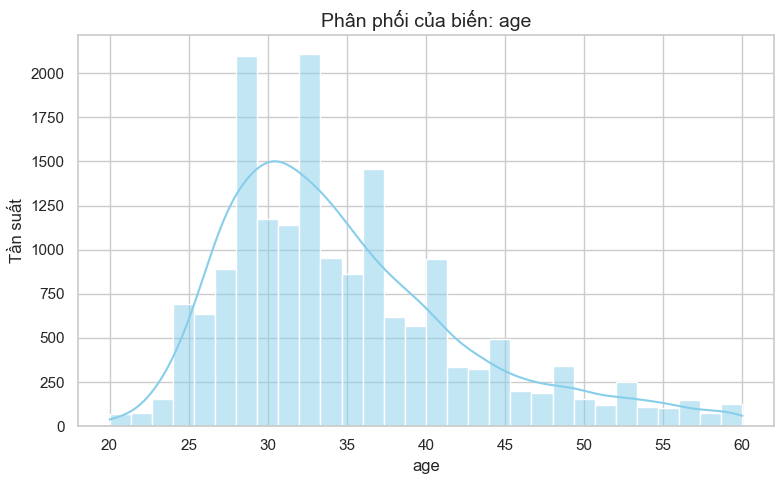

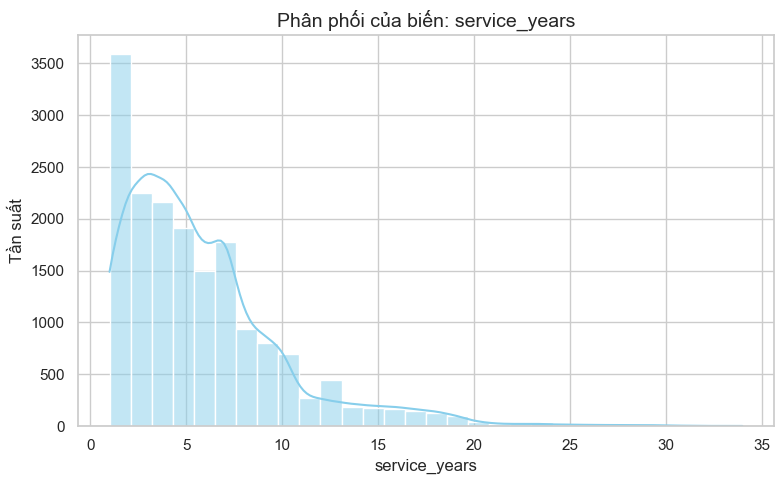

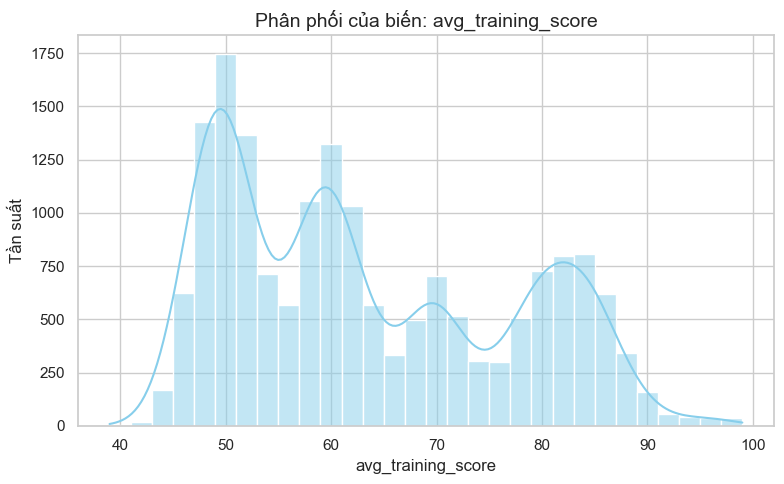

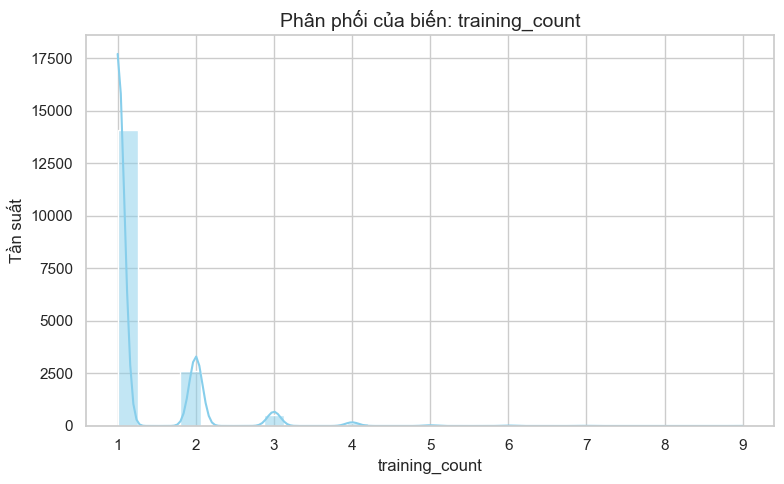

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\1956489957.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='performance_score', y=col, data=df, palette='Set2')


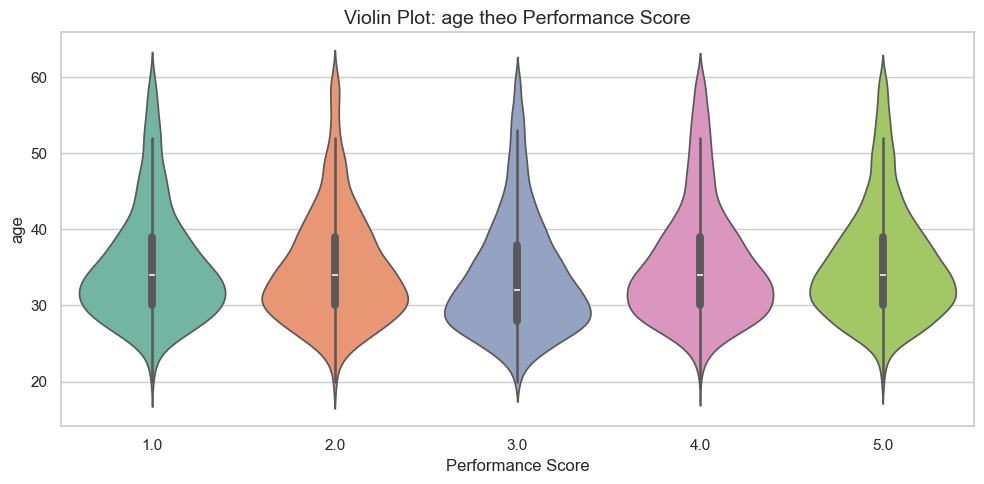

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\1956489957.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='performance_score', y=col, data=df, palette='Set2')


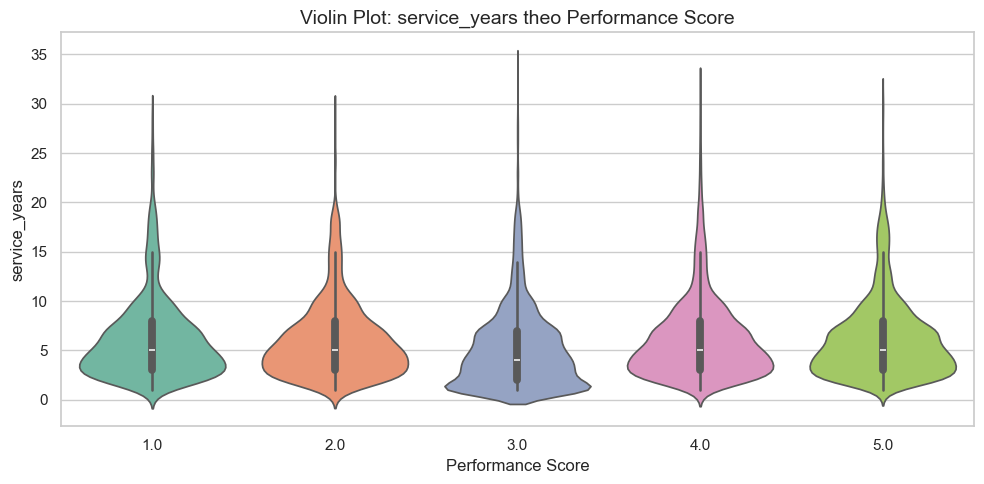

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\1956489957.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='performance_score', y=col, data=df, palette='Set2')


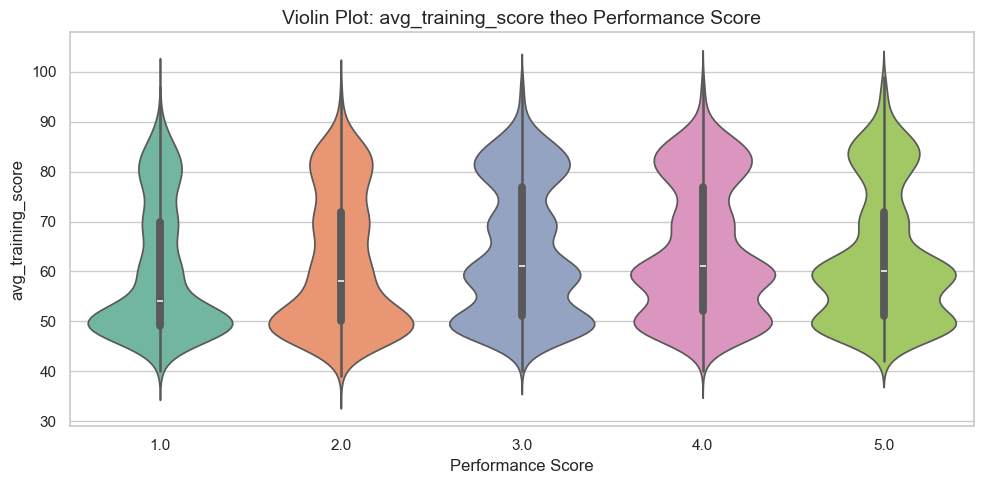

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\1956489957.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='performance_score', y=col, data=df, palette='Set2')


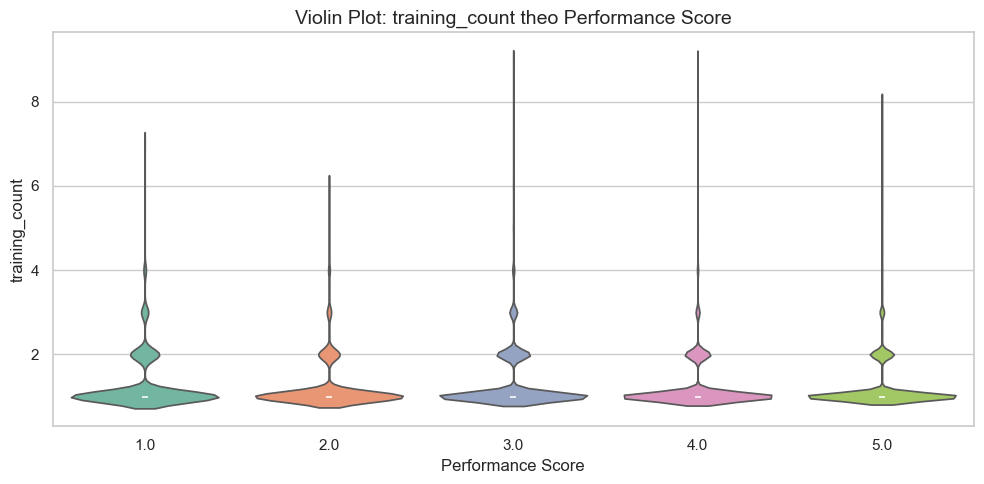

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\1956489957.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='performance_score', y=col, data=df, palette='Set3')


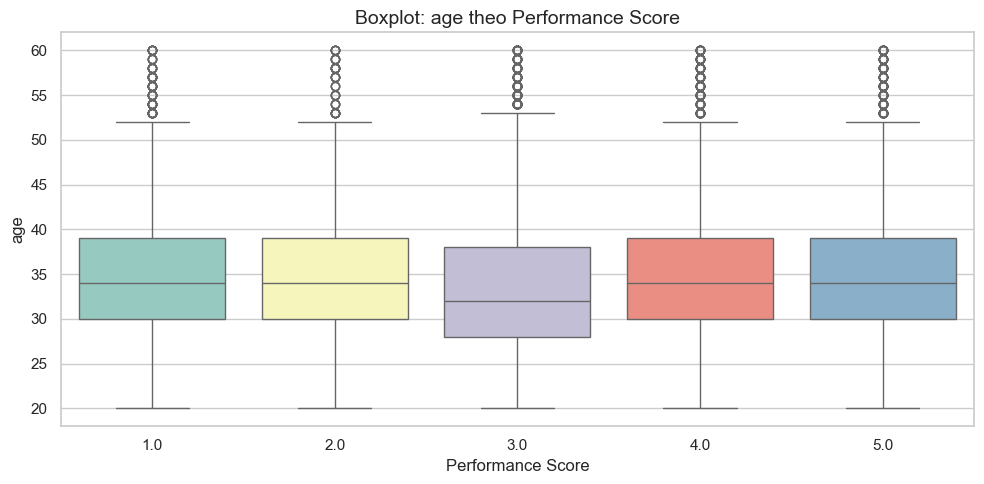

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\1956489957.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='performance_score', y=col, data=df, palette='Set3')


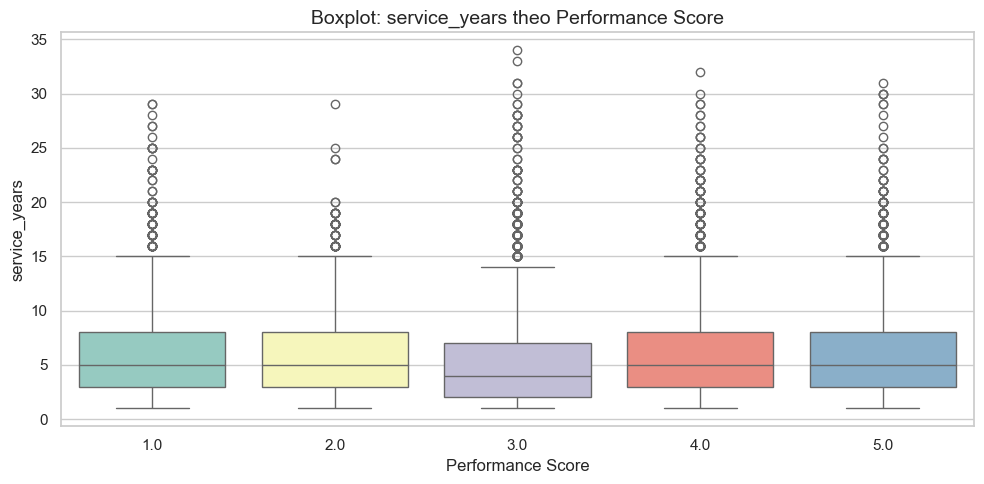

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\1956489957.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='performance_score', y=col, data=df, palette='Set3')


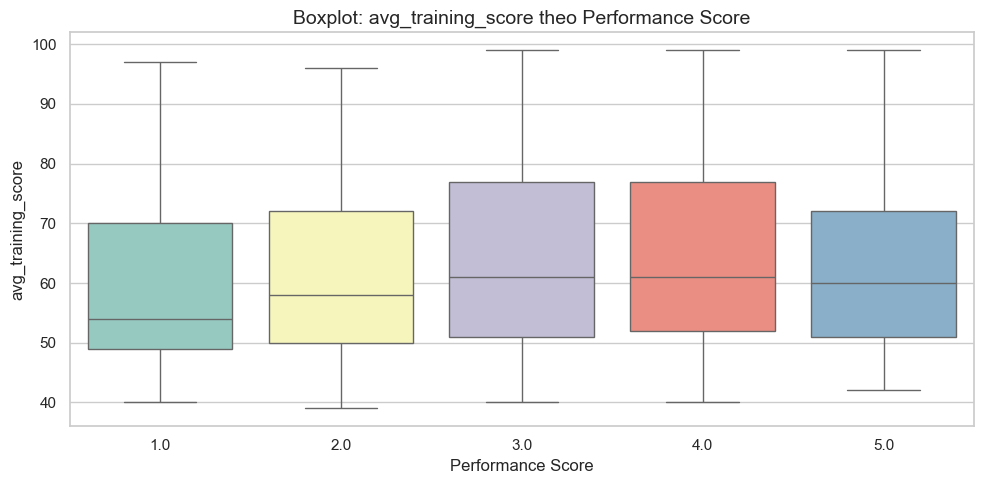

C:\Users\bichh\AppData\Local\Temp\ipykernel_3828\1956489957.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='performance_score', y=col, data=df, palette='Set3')


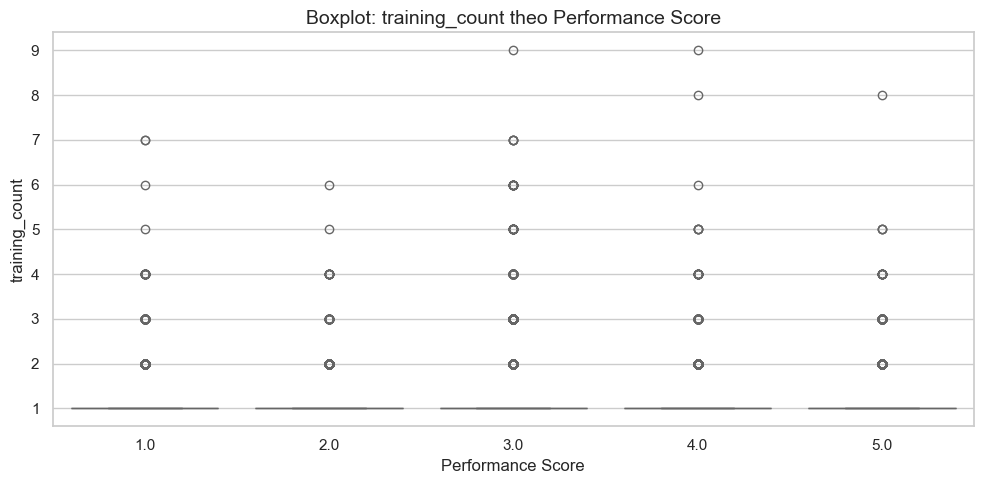

In [52]:
#Bi·∫øn li√™n t·ª•c:
#xem s·ª± ph√¢n b·ªï : [ age, service_years, avg_training_score, training_count]
# Danh s√°ch c√°c bi·∫øn li√™n t·ª•c c·∫ßn ph√¢n t√≠ch
continuous_cols = ['age', 'service_years', 'avg_training_score', 'training_count']
sns.set(style="whitegrid")
# V·∫Ω bi·ªÉu ƒë·ªì cho t·ª´ng bi·∫øn
for col in continuous_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Ph√¢n ph·ªëi c·ªßa bi·∫øn: {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel('T·∫ßn su·∫•t')
    plt.tight_layout()
    plt.show()

#xem xu h∆∞·ªõng thay ƒë·ªïi v·ªõi performance_score
# V·∫Ω bi·ªÉu ƒë·ªì  violin plot
for col in continuous_cols:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x='performance_score', y=col, data=df, palette='Set2')
    plt.title(f'Violin Plot: {col} theo Performance Score', fontsize=14)
    plt.xlabel('Performance Score')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()
# V·∫Ω bi·ªÉu ƒë·ªì Boxplot
for col in continuous_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='performance_score', y=col, data=df, palette='Set3')
    plt.title(f'Boxplot: {col} theo Performance Score', fontsize=14)
    plt.xlabel('Performance Score')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

Nh·∫≠n x√©t:

3. Bi·∫øn ph√¢n lo·∫°i
   - V·ªÅ s·ª± ph√¢n b·ªë:
     - age:
       + Bi·ªÉu ƒë·ªì cho th·∫•y ph√¢n ph·ªëi l·ªách ph·∫£i nh·∫π
       + ƒê·ªânh ph√¢n ph·ªëi n·∫±m trong kho·∫£ng 27‚Äì32 tu·ªïi
       + Ph√¢n ph·ªëi gi·∫£m d·∫ßn sau tu·ªïi 35, v√† r·∫•t √≠t ng∆∞·ªùi tr√™n 50 tu·ªïi.
    - service_years:
      + Bi·ªÉu ƒë·ªì cho th·∫•y ph√¢n ph·ªëi l·ªách ph·∫£i r√µ r·ªát.
      + ƒê·ªânh ph√¢n ph·ªëi n·∫±m ·ªü kho·∫£ng 2‚Äì5 nƒÉm ph·ª•c v·ª•
      + gi√° tr·ªã tr√™n 30 nƒÉm c√≥ th·ªÉ l√† outliers
    - avg_training_score:
      + ph√¢n ph·ªëi ƒëa ƒë·ªânh (multimodal).
      + C√≥ c√°c ƒë·ªânh r√µ r·ªát ·ªü kho·∫£ng 50, 60, 70 v√† 85 ƒëi·ªÉm
      + Ph√¢n ph·ªëi kh√° ƒë·ªÅu t·ª´ 40 ƒë·∫øn 100, kh√¥ng b·ªã l·ªách m·∫°nh v·ªÅ ph√≠a n√†o.
    - training_count:
      + Ph√¢n ph·ªëi l·ªách ph·∫£i c·ª±c m·∫°nh: G·∫ßn nh∆∞ to√†n b·ªô nh√¢n vi√™n ch·ªâ ƒë∆∞·ª£c ƒë√†o t·∫°o 1‚Äì2 l·∫ßn.
      + C√≥ gi√° tr·ªã ngo·∫°i lai: M·ªôt s·ªë c√° nh√¢n c√≥ ƒë·∫øn 8‚Äì9 l·∫ßn ƒë√†o t·∫°o

- V·ªÅ xu h∆∞·ªõng thay ƒë·ªïi theo performance_score:

      - age:
        + Nh√≥m ƒëi·ªÉm th·∫•p (1.0‚Äì2.0): tu·ªïi th·∫•p h∆°n, Ph√¢n ph·ªëi t·∫≠p trung ·ªü tu·ªïi 25‚Äì32, Trung v·ªã tu·ªïi th·∫•p h∆°n so v·ªõi c√°c nh√≥m ƒëi·ªÉm cao, med =28
        + Nh√≥m ƒëi·ªÉm trung b√¨nh (3.0): tu·ªïi ph·ªï bi·∫øn, l√† nh√≥m ƒë√¥ng nh·∫•t, ph√¢n ph·ªëi r·ªông t·ª´ 25‚Äì40 tu·ªïi, med = 30,
        + Nh√≥m ƒëi·ªÉm cao (4.0‚Äì5.0): tu·ªïi cao h∆°n, ph√¢n ph·ªëi l·ªách v·ªÅ ph√≠a 30‚Äì45 tu·ªïi, med cao =35
        + Ngo·∫°i lai: M·ªôt s·ªë c√° nh√¢n tr√™n 60 tu·ªïi ho·∫∑c d∆∞·ªõi 22 tu·ªïi
        + Xu h∆∞·ªõng:  Bi·∫øn age c√≥ xu h∆∞·ªõng tƒÉng nh·∫π theo performance_score

    - service_years:
      + Nh√≥m ƒëi·ªÉm th·∫•p (1.0‚Äì2.0): th√¢m ni√™n th·∫•p, Ph√¢n ph·ªëi t·∫≠p trung ·ªü 1‚Äì5 nƒÉm ph·ª•c v·ª•, med = 2
      + Nh√≥m ƒëi·ªÉm trung b√¨nh (3.0): th√¢m ni√™n ph·ªï bi·∫øn, Ph√¢n ph·ªëi r·ªông t·ª´ 2‚Äì10 nƒÉm, med = 4
      + Nh√≥m ƒëi·ªÉm cao (4.0‚Äì5.0): th√¢m ni√™n cao h∆°n, Ph√¢n ph·ªëi l·ªách v·ªÅ ph√≠a 6‚Äì15 nƒÉm, med = 6
      + Ngo·∫°i lai: M·ªôt s·ªë c√° nh√¢n c√≥ th√¢m ni√™n tr√™n 25‚Äì30 nƒÉm
      + Xu h∆∞·ªõng: Bi·∫øn service_years c√≥ xu h∆∞·ªõng tƒÉng r√µ r·ªát theo performance_score
  
    - avg_training_score:
      + Nh√≥m ƒëi·ªÉm th·∫•p (1.0‚Äì2.0): ƒëi·ªÉm ƒë√†o t·∫°o th·∫•p, Ph√¢n ph·ªëi t·∫≠p trung ·ªü kho·∫£ng 40‚Äì60 ƒëi·ªÉm, med = 50
      + Nh√≥m ƒëi·ªÉm trung b√¨nh (3.0): ƒëi·ªÉm ƒë√†o t·∫°o ph·ªï bi·∫øn, Ph√¢n ph·ªëi r·ªông t·ª´ 50‚Äì75 ƒëi·ªÉm, med =65
      + Nh√≥m ƒëi·ªÉm cao (4.0‚Äì5.0): ƒëi·ªÉm ƒë√†o t·∫°o cao, Ph√¢n ph·ªëi l·ªách v·ªÅ ph√≠a 70‚Äì90 ƒëi·ªÉm, med = 80
      + Ngo·∫°i lai: √≠t v√† h·ª£p l√Ω, m·ªôt v√†i ƒëi·ªÉm d∆∞·ªõi 45 ho·∫∑c tr√™n 90, kh√¥ng qu√° b·∫•t th∆∞·ªùng
      + Xu h∆∞·ªõng:  Bi·∫øn avg_training_score l√† bi·∫øn d·ª± b√°o m·∫°nh nh·∫•t trong nh√≥m li√™n t·ª•c
  
    - training_count:
      + Ph√¢n ph·ªëi l·ªách ph·∫£i ·ªü m·ªçi nh√≥m ƒëi·ªÉm: H·∫ßu h·∫øt c√°c nh√≥m ƒë·ªÅu c√≥ m·∫≠t ƒë·ªô t·∫≠p trung ·ªü training_count = 1
      + med ƒë·ªÅu b·∫±ng 1 ·ªü c√°c nh√≥m
      + Ngo·∫°i lai: xu·∫•t hi·ªán ·ªü m·ªçi nh√≥m, m·ªôt s·ªë c√° nh√¢n c√≥ ƒë·∫øn 8‚Äì9 l·∫ßn ƒë√†o t·∫°o, nh∆∞ng kh√¥ng t·∫≠p trung ·ªü nh√≥m ƒëi·ªÉm cao
      + Xu h∆∞·ªõng: Bi·∫øn training_count KH√îNG c√≥ xu h∆∞·ªõng r√µ r·ªát theo performance_score

t∆∞∆°ng quan gi·ªØa c√°c bi·∫øn li√™n t·ª•c:

 Ma tr·∫≠n t∆∞∆°ng quan Pearson gi·ªØa c√°c bi·∫øn li√™n t·ª•c:
                         age  service_years  avg_training_score  \
age                 1.000000       0.641175           -0.028074   
service_years       0.641175       1.000000           -0.026311   
avg_training_score -0.028074      -0.026311            1.000000   
training_count     -0.085722      -0.061190            0.045242   

                    training_count  
age                      -0.085722  
service_years            -0.061190  
avg_training_score        0.045242  
training_count            1.000000  


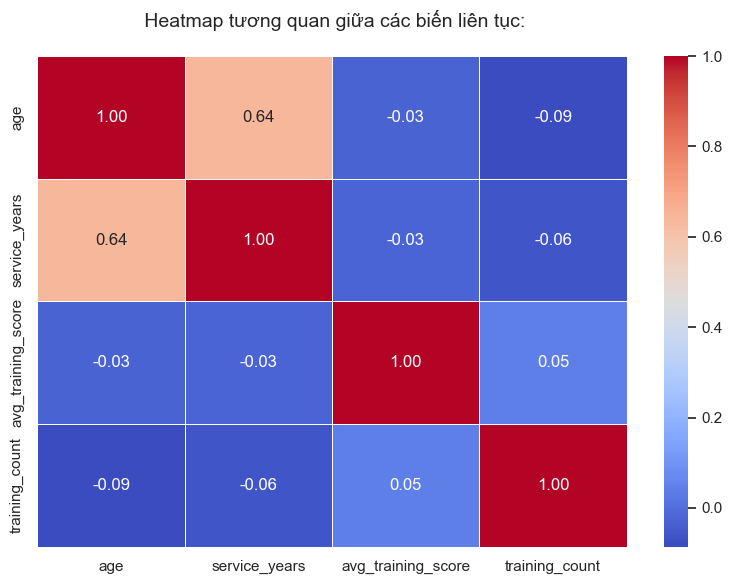

t∆∞∆°ng quan gi·ªØa bi·∫øn li√™n t·ª•c v√† performance_score:

                 Bi·∫øn  Kendall's Tau  P-Value
0                 age         0.0452      0.0
1       service_years         0.0485      0.0
2  avg_training_score         0.0456      0.0
3      training_count        -0.0457      0.0

t∆∞∆°ng quan gi·ªØa bi·∫øn ph√¢n lo·∫°i v√† performance_score:

          Bi·∫øn ph√¢n lo·∫°i  Chi-square p-value  Cramer's V
0             department              0.0000      0.1091
1                 region              0.0000      0.0674
2              education              0.0000      0.0540
3                 gender              0.0007      0.0332
4    recruitment_channel              0.0000      0.0465
5  KPIs_met_more_than_80              0.0000      0.3431
6                 awards              0.0001      0.0374


In [53]:
# 4. Ph√¢n t√≠ch t∆∞∆°ng quan
print("t∆∞∆°ng quan gi·ªØa c√°c bi·∫øn li√™n t·ª•c:\n")
# Danh s√°ch bi·∫øn li√™n t·ª•c
continuous_vars = ['age', 'service_years', 'avg_training_score', 'training_count']
correlation_matrix = df[continuous_vars].corr(method='pearson')
print(" Ma tr·∫≠n t∆∞∆°ng quan Pearson gi·ªØa c√°c bi·∫øn li√™n t·ª•c:")
print(correlation_matrix)
# V·∫Ω bi·ªÉu ƒë·ªì heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title(' Heatmap t∆∞∆°ng quan gi·ªØa c√°c bi·∫øn li√™n t·ª•c:\n', fontsize=14)
plt.tight_layout()
plt.show()

print("t∆∞∆°ng quan gi·ªØa bi·∫øn li√™n t·ª•c v√† performance_score:\n")
continuous_vars = ['age', 'service_years', 'avg_training_score', 'training_count']
# T√≠nh Kendall's Tau gi·ªØa performance_score v√† t·ª´ng bi·∫øn
results = []
for var in continuous_vars:
    tau, p_value = kendalltau(df['performance_score'], df[var])
    results.append({
        'Bi·∫øn': var,
        "Kendall's Tau": round(tau, 4),
        'P-Value': round(p_value, 4)
    })
# Hi·ªÉn th·ªã k·∫øt qu·∫£ d∆∞·ªõi d·∫°ng b·∫£ng
correlation_df = pd.DataFrame(results)
print(correlation_df)
print("")
print("t∆∞∆°ng quan gi·ªØa bi·∫øn ph√¢n lo·∫°i v√† performance_score:\n")
# H√†m t√≠nh Cramer's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))
# Danh s√°ch bi·∫øn ph√¢n lo·∫°i c·∫ßn ki·ªÉm ƒë·ªãnh
categorical_vars = ['department', 'region', 'education', 'gender',
                    'recruitment_channel', 'KPIs_met_more_than_80', 'awards']
results = []
for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['performance_score'])
    # Ki·ªÉm ƒë·ªãnh Chi-square
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # T√≠nh Cramer's V
    cramer_v = cramers_v(contingency_table)
    
    results.append({
        'Bi·∫øn ph√¢n lo·∫°i': var,
        'Chi-square p-value': round(p, 4),
        "Cramer's V": round(cramer_v, 4)
    })
correlation_df = pd.DataFrame(results)
print(correlation_df)


4. Ph√¢n t√≠ch t∆∞∆°ng quan:

Nh·∫≠n x√©t:

- V·ªÅ t∆∞∆°ng quan gi·ªØa c√°c bi·∫øn li√™n t·ª•c:
    + C·∫∑p c√≥ t∆∞∆°ng quan v·ª´a m·∫°nh: age ‚Üî service_years
    + C√°c c·∫∑p c√≤n l·∫°i t∆∞∆°ng quan r·∫•t y·∫øu 
- V·ªÅ t∆∞∆°ng quan gi·ªØa bi·∫øn li√™n t·ª•c v√† bi·∫øn m·ª•c ti√™u:
    + avg_training_score: C√≥ xu h∆∞·ªõng r√µ r·ªát trong bi·ªÉu ƒë·ªì, d√π h·ªá s·ªë th·∫•p
    + service_years: C√≥ xu h∆∞·ªõng tƒÉng theo hi·ªáu su·∫•t, h·ªó tr·ª£ t·ªët cho m√¥ h√¨nh
    + age: C√≥ th·ªÉ k·∫øt h·ª£p v·ªõi service_years ƒë·ªÉ tƒÉng ƒë·ªô ph√¢n bi·ªát, c√≥ xu h∆∞·ªõng tƒÉng khi performance_score tƒÉng
    + training_count: c√≥ th·ªÉ t·∫°o bi·∫øn t·ªï h·ª£p nh∆∞ training_efficiency = avg_training_score / training ; c√≥ xu h∆∞·ªõng gi·∫£m khi performance_score tƒÉng
- V·ªÅ t∆∞∆°ng quan c·ªßa bi·∫øn ph√¢n lo·∫°i v·ªõi bi·∫øn m·ª•c ti√™u:
    + KPIs_met_more_than_80: Cramer's V = 0.3431 ‚Üí li√™n h·ªá m·∫°nh ‚Üí bi·∫øn d·ª± b√°o c·ª±c k·ª≥ t·ªët
    + department: Cramer's V = 0.1091 ‚Üí c√≥ s·ª± kh√°c bi·ªát hi·ªáu su·∫•t gi·ªØa c√°c ph√≤ng ban ‚Üí n√™n gi·ªØ l·∫°i
    + region: li√™n h·ªá y·∫øu, nh∆∞ng c√≥ th·ªÉ gi·ªØ n·∫øu x·ª≠ l√Ω nh√≥m nh·ªè
    + recruitment_channel: li√™n h·ªá y·∫øu
    + gender, education, awards: li√™n h·ªá r·∫•t y·∫øu 
                                            
                                            

==========T·ªîNG K·∫æT SAU B∆Ø·ªöC EDA==============================

c·∫ßn th·ª±c hi·ªán c√°c b∆∞·ªõc sau: 
- x·ª≠ l√Ω outlier
- g·ªôp nh√≥m region => region_grouped
- smoothing target encoding cho c√°c bi·∫øn: department, region_grouped, recruitment_channel
- ordinal encoding cho bi·∫øn: education
- t·∫°o bi·∫øn t·ªï h·ª£p: 'training_efficiency' = 'avg_training_score' / 'training_count'
- drop c√°c colums kh√¥ng tham gia v√†o m√¥ h√¨nh
- Chia d·ªØ li·ªáu
- Scaling bi·∫øn li√™n t·ª•c
- x·ª≠ l√Ω m·∫•t c√¢n b·∫±ng SMOTE cho performance_score tr√™n t·∫≠p train
- Hu·∫•n luy·ªán m√¥ h√¨nh, ƒë√°nh gi√° m√¥ h√¨nh
- c·∫£i ti·∫øn m√¥ h√¨nh

In [54]:
# x·ª≠ l√Ω outlier - ƒë∆∞a v·ªÅ ng∆∞·ª°ng 
def winsorize_series(s, lower_quantile=0.05, upper_quantile=0.95):
    lower = s.quantile(lower_quantile)
    upper = s.quantile(upper_quantile)
    return s.clip(lower, upper)

# √Åp d·ª•ng cho c√°c bi·∫øn li√™n t·ª•c
for col in ['age', 'service_years', 'training_count']:
    df[col] = winsorize_series(df[col])

In [55]:
# G·ªôp nh√≥m region
region_freq = df['region'].value_counts(normalize=True)
rare_regions = region_freq[region_freq < 0.01].index.tolist()
# G·ªôp nh√≥m hi·∫øm th√†nh 'Other_Region'
df['region'] = df['region'].apply(lambda x: 'Other_Region' if x in rare_regions else x)
# Ki·ªÉm tra ph√¢n ph·ªëi sau khi g·ªôp
print(df['region'].value_counts(normalize=True))

region
region_2        0.224991
region_22       0.114276
region_7        0.085276
Other_Region    0.062938
region_13       0.049386
region_15       0.048409
region_26       0.042954
region_31       0.037097
region_4        0.032790
region_27       0.029631
region_16       0.025956
region_28       0.024693
region_11       0.024119
region_23       0.021592
region_32       0.018261
region_19       0.018089
region_29       0.017687
region_17       0.015390
region_14       0.015218
region_5        0.014471
region_25       0.014241
region_20       0.013897
region_6        0.012634
region_8        0.012002
region_10       0.012002
region_30       0.012002
Name: proportion, dtype: float64


In [56]:
# Smoothing target encoding
def target_encode_smooth(df, col, target, k=10):
    global_mean = df[target].mean()
    agg = df.groupby(col)[target].agg(['mean', 'count'])
    smooth = (agg['count'] * agg['mean'] + k * global_mean) / (agg['count'] + k)
    return df[col].map(smooth)
for col in ['department', 'region', 'recruitment_channel']:
    df[f'{col}_encoded'] = target_encode_smooth(df, col, 'performance_score', k=10)

# ordinal encoding cho education
education_order = {
    'Below Secondary': 0,
    'Bachelors': 1,
    'Masters & above': 2
}
df['education_encoded'] = df['education'].map(education_order)

In [57]:
#t·∫°o bi·∫øn t·ªï h·ª£p: 'training_efficiency' = 'avg_training_score' / 'training_count'
# hi·ªáu su·∫•t ƒë√†o t·∫°o:
df['training_efficiency'] = df['avg_training_score'] / df['training_count']

In [58]:
# drop c√°c colums d∆∞ th·ª´a
cols_to_drop = [
    'employee_id', 'gender', 'age', 'awards', 'training_count',
    'recruitment_channel', 'education', 'region', 'department'
]
df = df.drop(columns=cols_to_drop)

In [59]:
# chia d·ªØ li·ªáu
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['performance_score'])

In [60]:
#scaling
scaler = StandardScaler()
num_cols = ['service_years', 'avg_training_score', 'training_efficiency']
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

In [30]:
# x·ª≠ l√Ω m·∫•t c√¢n b·∫±ng SMOTE cho performance_score tr√™n t·∫≠p train
# 1. t·∫°o X_train, y_train, X_test, y_test
X_train = train_df.drop(columns=['performance_score'])
y_train = train_df['performance_score']
X_test = test_df.drop(columns=['performance_score'])
y_test = test_df['performance_score']

#2. SMOTE tr√™n t·∫≠p train
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


LOGISTIC REGRESSION
- hu·∫•n luy·ªán
- ƒë√°nh gi√° : accuracy 0.32
- nh·∫≠n x√©t: m√¥ h√¨nh ch∆∞a ƒë·ªß m·∫°nh
- c·∫£i thi·ªán: chuy·ªÉn sang XGBClassifier, t·∫°o th√™m feature engineering ƒë·ªÉ m√¥ h√¨nh h·ªçc t·ªët h∆°n

C:\Users\bichh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Logistic Regression Report:
              precision    recall  f1-score   support

         1.0       0.20      0.46      0.28       395
         2.0       0.12      0.18      0.14       259
         3.0       0.54      0.26      0.35      1435
         4.0       0.26      0.12      0.17       631
         5.0       0.37      0.59      0.46       763

    accuracy                           0.32      3483
   macro avg       0.30      0.32      0.28      3483
weighted avg       0.38      0.32      0.32      3483



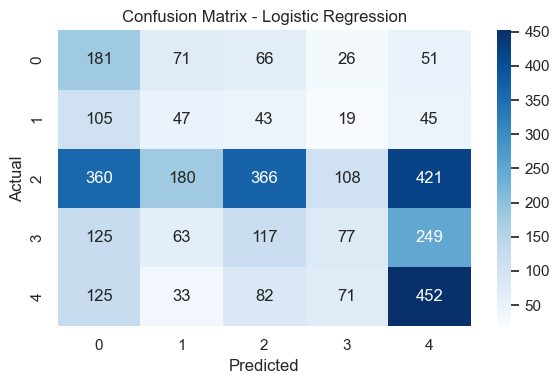

                             importance
recruitment_channel_encoded    1.680047
department_encoded             0.945862
region_encoded                 0.809532
KPIs_met_more_than_80          0.730641
avg_training_score             0.099182
service_years                  0.093746
training_efficiency            0.065195
education_encoded              0.025853


In [32]:
lr = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs'
)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
# ƒë√°nh gi√°
print("  Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
#coefficients
feature_names = X_train.columns
coefficients = lr.coef_
importance = pd.DataFrame(
    data=abs(coefficients).mean(axis=0),
    index=feature_names,
    columns=['importance']
).sort_values(by='importance', ascending=False)
print(importance)

XGBOOSTCLASSIFIER
- hu·∫•n luy·ªán
- ƒë√°nh gi√°: accuracy: 0.73
- nh·∫≠n x√©t: c·∫£i thi·ªán hi·ªáu su·∫•t m√¥ h√¨nh so v·ªõi logistic regression
- c√°c b∆∞·ªõc c·∫£i thi·ªán:
+ g·ªôp nh√£n bi·∫øn m·ª•c ti√™u
+ t·∫°o c√°c bi·∫øn t∆∞∆°ng t√°c gi√∫p m√¥ h√¨nh ph√¢n bi·ªát r√µ l·ªõp low
+ tuning

üìä XGBoost Report (Grouped Classes):
              precision    recall  f1-score   support

        High       0.65      0.70      0.67      1394
         Low       1.00      1.00      1.00       654
      Medium       0.69      0.63      0.66      1435

    accuracy                           0.73      3483
   macro avg       0.78      0.78      0.78      3483
weighted avg       0.73      0.73      0.73      3483



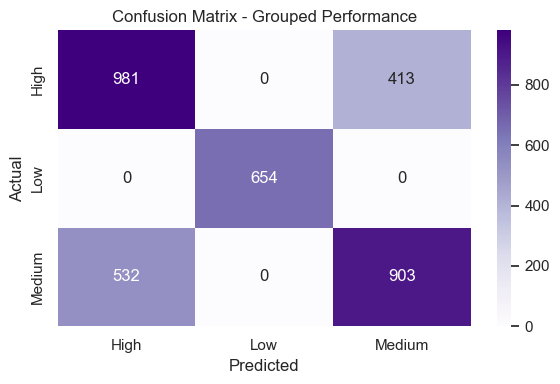

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

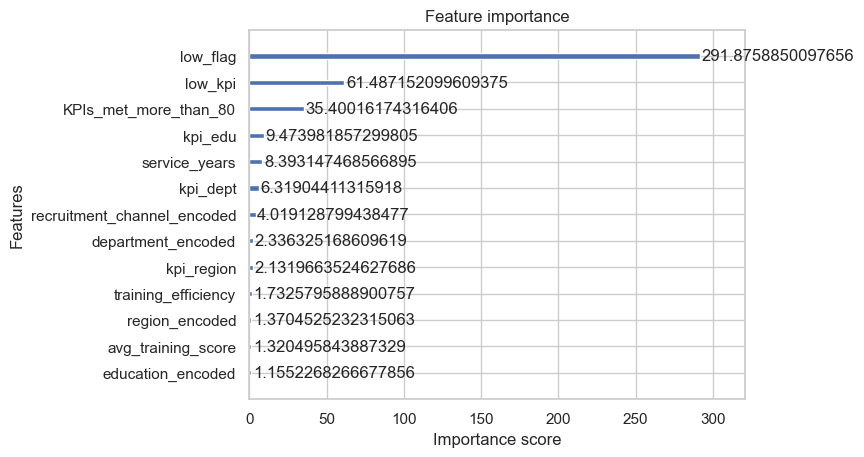

In [62]:
# g·ªôp nh√£n bi·∫øn m·ª•c ti√™u performance_score
def simplify_score(x):
    if x in [1, 2]:
        return 'Low'
    elif x == 3:
        return 'Medium'
    else:
        return 'High'

train_df['performance_group'] = train_df['performance_score'].apply(simplify_score)
test_df['performance_group'] = test_df['performance_score'].apply(simplify_score)

# T·∫°o bi·∫øn t∆∞∆°ng t√°c
train_df['kpi_edu'] = train_df['KPIs_met_more_than_80'] * train_df['education_encoded']
train_df['kpi_dept'] = train_df['KPIs_met_more_than_80'] * train_df['department_encoded']
train_df['kpi_region'] = train_df['KPIs_met_more_than_80'] * train_df['region_encoded']
train_df['low_flag'] = (train_df['performance_group'] == 'Low').astype(int)
train_df['low_kpi'] = train_df['low_flag'] * train_df['KPIs_met_more_than_80']

test_df['kpi_edu'] = test_df['KPIs_met_more_than_80'] * test_df['education_encoded']
test_df['kpi_dept'] = test_df['KPIs_met_more_than_80'] * test_df['department_encoded']
test_df['kpi_region'] = test_df['KPIs_met_more_than_80'] * test_df['region_encoded']
test_df['low_flag'] = (test_df['performance_group'] == 'Low').astype(int)
test_df['low_kpi'] = test_df['low_flag'] * test_df['KPIs_met_more_than_80']

# t·∫°o t·∫≠p train, t·∫≠p test ƒë·∫ßu v√†o
features_final = [
    'department_encoded',
    'region_encoded',
    'recruitment_channel_encoded',
    'service_years',
    'avg_training_score',
    'training_efficiency',
    'education_encoded',
    'KPIs_met_more_than_80',
    'kpi_edu',
    'kpi_dept',
    'kpi_region',
    'low_flag',
    'low_kpi'
]

X_train = train_df[features_final]
X_test = test_df[features_final]

# Encode nh√£n
le = LabelEncoder()
y_train = le.fit_transform(train_df['performance_group'])
y_test = le.transform(test_df['performance_group'])

# SMOTE
smote = SMOTE(random_state=42)
X_train,y_train = smote.fit_resample(X_train, y_train)

#XGBClassifier
# Tuning nh·∫π
xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
# ƒë√°nh gi√°
print(" XGBoost Report (Grouped Classes):")
print(classification_report(y_test, y_pred, target_names=le.classes_))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Grouped Performance')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
# feature importance
plot_importance(xgb_model, max_num_features=13, importance_type='gain')